In [1]:
import sqlite3
import csv

# Load CSV file
file_path = 'loan_data.csv'  # Replace with your CSV file path

# Create an SQLite database
conn = sqlite3.connect('normalized_data.db')
cursor = conn.cursor()

# Create normalized tables
cursor.execute('''
CREATE TABLE IF NOT EXISTS Person (
    person_id INTEGER PRIMARY KEY AUTOINCREMENT,
    age REAL,
    gender TEXT,
    education TEXT,
    income REAL,
    emp_exp REAL,
    home_ownership TEXT
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Loan (
    loan_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_id INTEGER,
    amount REAL,
    intent TEXT,
    interest_rate REAL,
    percent_income REAL,
    FOREIGN KEY(person_id) REFERENCES Person(person_id)
);
''')

cursor.execute('''
CREATE TABLE IF NOT EXISTS Credit (
    credit_id INTEGER PRIMARY KEY AUTOINCREMENT,
    person_id INTEGER,
    cred_hist_length REAL,
    credit_score REAL,
    prev_defaults TEXT,
    loan_status INTEGER,
    FOREIGN KEY(person_id) REFERENCES Person(person_id)
);
''')

# Insert data into tables
with open(file_path, 'r') as csv_file:
    csv_reader = csv.DictReader(csv_file)
    for row in csv_reader:
        # Insert into Person table
        cursor.execute('''
        INSERT INTO Person (age, gender, education, income, emp_exp, home_ownership)
        VALUES (?, ?, ?, ?, ?, ?)
        ''', (float(row['person_age']), row['person_gender'], row['person_education'], 
              float(row['person_income']), float(row['person_emp_exp']), row['person_home_ownership']))

        person_id = cursor.lastrowid  # Get the last inserted ID

        # Insert into Loan table
        cursor.execute('''
        INSERT INTO Loan (person_id, amount, intent, interest_rate, percent_income)
        VALUES (?, ?, ?, ?, ?)
        ''', (person_id, float(row['loan_amnt']), row['loan_intent'], 
              float(row['loan_int_rate']), float(row['loan_percent_income'])))

        # Insert into Credit table
        cursor.execute('''
        INSERT INTO Credit (person_id, cred_hist_length, credit_score, prev_defaults, loan_status)
        VALUES (?, ?, ?, ?, ?)
        ''', (person_id, float(row['cb_person_cred_hist_length']), float(row['credit_score']), 
              row['previous_loan_defaults_on_file'], int(row['loan_status'])))

# Commit changes and close connection
conn.commit()
conn.close()

print("Data normalization and insertion completed!")


Data normalization and insertion completed!


In [3]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect('normalized_data.db')
cursor = conn.cursor()

# Example SQL query to join tables and fetch data
query = '''
SELECT 
    p.person_id,
    p.age,
    p.gender,
    p.education,
    p.income,
    l.amount AS loan_amount,
    l.intent AS loan_intent,
    c.credit_score,
    c.loan_status
FROM 
    Person p
JOIN 
    Loan l ON p.person_id = l.person_id
JOIN 
    Credit c ON p.person_id = c.person_id;
'''

df = pd.read_sql_query(query, conn)
print(df.head())

# Close the connection
conn.close()

print("Data normalization and DataFrame creation completed!")



   person_id   age  gender    education   income  loan_amount loan_intent  \
0          1  22.0  female       Master  71948.0      35000.0    PERSONAL   
1          2  21.0  female  High School  12282.0       1000.0   EDUCATION   
2          3  25.0  female  High School  12438.0       5500.0     MEDICAL   
3          4  23.0  female     Bachelor  79753.0      35000.0     MEDICAL   
4          5  24.0    male       Master  66135.0      35000.0     MEDICAL   

   credit_score  loan_status  
0         561.0            1  
1         504.0            0  
2         635.0            1  
3         675.0            1  
4         586.0            1  
Data normalization and DataFrame creation completed!


In [5]:
import mlflow
import os

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"


In [11]:
import mlflow
import os
from sklearn.model_selection import train_test_split

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Ensure df is defined
# df should be a DataFrame. If it is not defined in your script, replace this comment with the correct DataFrame loading code.
# Example: df = pd.read_csv('your_data.csv')

# Separate features and target variable
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

# Perform train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Log train/test split information to MLflow
with mlflow.start_run(run_name="Train Test Split"):
    mlflow.log_param("test_size", 0.2)
    mlflow.log_param("random_state", 42)
    mlflow.log_param("stratify", True)

# Confirm stratification
print("Train target distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest target distribution:")
print(y_test.value_counts(normalize=True))


🏃 View run Train Test Split at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0/runs/12eacce42d24444e928c96ace9508b19
🧪 View experiment at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0
Train target distribution:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64

Test target distribution:
loan_status
0    0.777778
1    0.222222
Name: proportion, dtype: float64


In [13]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Step 4.1: Generate and display a profile report interactively
profile = ProfileReport(df, title="Data Exploration Report", explorative=True)
profile_path = "profile_report.html"
profile.to_file(profile_path)
mlflow.log_artifact(profile_path)  # Log the profile report to DagsHub

# Step 4.2: Generate a correlation matrix
# Select only numeric columns to avoid errors
numeric_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(10, 8))
correlation_matrix = numeric_df.corr()
heatmap_path = "correlation_matrix.png"
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Matrix")
plt.savefig(heatmap_path)  # Save the heatmap as an image file
plt.close()  # Close the plot to avoid overlap
mlflow.log_artifact(heatmap_path)  # Log the heatmap to DagsHub

# Step 4.3: Analyze missing values
missing_values = df.isnull().sum()
missing_values_path = "missing_values.csv"
missing_values.to_csv(missing_values_path)
mlflow.log_artifact(missing_values_path)  # Log missing values to DagsHub

# Step 4.4: Check feature distributions
for column in numeric_df.columns:
    distribution_path = f"distribution_{column}.png"
    plt.figure()
    sns.histplot(df[column], kde=True, bins=30)
    plt.title(f"Distribution of {column}")
    plt.savefig(distribution_path)  # Save each plot as an image file
    plt.close()  # Close the plot to avoid overlap
    mlflow.log_artifact(distribution_path)  # Log each distribution plot to DagsHub

# Step 4.5: Identify capped values
capped_values = {}
for column in numeric_df.columns:
    capped_values[column] = {
        "max_value": df[column].max(),
        "min_value": df[column].min()
    }
capped_values_df = pd.DataFrame(capped_values).T
capped_values_path = "capped_values.csv"
capped_values_df.to_csv(capped_values_path)
mlflow.log_artifact(capped_values_path)  # Log capped values to DagsHub

print("\nData exploration completed. Outputs logged to DagsHub via MLflow.")


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]


Data exploration completed. Outputs logged to DagsHub via MLflow.


In [17]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, make_scorer
import numpy as np

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Train/Test Split
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Model Pipeline
numeric_features = ['age', 'income', 'loan_amount', 'credit_score']
categorical_features = ['gender', 'education', 'loan_intent']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

model = LogisticRegression(max_iter=1000, random_state=42)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', model)
])

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer)

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
conf_matrix = confusion_matrix(y_train, y_train_pred)

results = {
    "mean_f1_cv": np.mean(cv_scores),
    "std_f1_cv": np.std(cv_scores),
    "confusion_matrix": conf_matrix
}

# Ensure there is no active run
mlflow.end_run()  # Safely end any active runs before starting a new one

# Log model results to MLflow
with mlflow.start_run(run_name="Model Training"):
    mlflow.log_param("cv_splits", 3)
    mlflow.log_param("random_state", 42)
    mlflow.log_metric("mean_f1_cv", results["mean_f1_cv"])
    mlflow.log_metric("std_f1_cv", results["std_f1_cv"])
    conf_matrix_path = "confusion_matrix.csv"
    pd.DataFrame(results["confusion_matrix"]).to_csv(conf_matrix_path, index=False)
    mlflow.log_artifact(conf_matrix_path)

print("Results:")
print(f"Mean F1-score (CV): {results['mean_f1_cv']}")
print(f"Std F1-score (CV): {results['std_f1_cv']}")
print(f"Confusion Matrix (Training Data):\n{results['confusion_matrix']}")


🏃 View run industrious-frog-655 at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0/runs/7ab3594dcdd84fafb77432076bdf331f
🧪 View experiment at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0
🏃 View run Model Training at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0/runs/88450503fd6f44558fafe3ada6cac190
🧪 View experiment at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0
Results:
Mean F1-score (CV): 0.28609852603663305
Std F1-score (CV): 0.006813496052382139
Confusion Matrix (Training Data):
[[27500   500]
 [ 6568  1432]]


In [19]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
import numpy as np

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Train/Test Split
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define numeric and categorical features
numeric_features = ['age', 'income', 'loan_amount', 'credit_score']
categorical_features = ['gender', 'education', 'loan_intent']

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Define models
models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=42),
    'RidgeClassifier': RidgeClassifier(random_state=42),
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Evaluate each model
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer)
    
    # Log results
    results[model_name] = {
        'mean_f1_cv': np.mean(cv_scores),
        'std_f1_cv': np.std(cv_scores)
    }

# Ensure there is no active run
mlflow.end_run()  # Safely end any active runs before starting a new one

# Log all model results to MLflow
with mlflow.start_run(run_name="Model Comparisons"):
    for model_name, result in results.items():
        mlflow.log_metric(f"{model_name}_mean_f1_cv", result['mean_f1_cv'])
        mlflow.log_metric(f"{model_name}_std_f1_cv", result['std_f1_cv'])

# Display results
for model_name, result in results.items():
    print(f"{model_name}: Mean F1-score (CV): {result['mean_f1_cv']:.4f}, Std: {result['std_f1_cv']:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:05:01] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:05:02] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:05:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🏃 View run Model Comparisons at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0/runs/80b6e031b66f42b4b76c53c96feb33ba
🧪 View experiment at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0
LogisticRegression: Mean F1-score (CV): 0.2861, Std: 0.0068
RidgeClassifier: Mean F1-score (CV): 0.0082, Std: 0.0065
RandomForest: Mean F1-score (CV): 0.5456, Std: 0.0068
XGBClassifier: Mean F1-score (CV): 0.5858, Std: 0.0040


In [21]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
import numpy as np

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Train/Test Split
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define numeric and categorical features
numeric_features = ['age', 'income', 'loan_amount', 'credit_score']
categorical_features = ['gender', 'education', 'loan_intent']

# Custom feature engineering function
def add_features(X):
    # Ensure input is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=numeric_features)
    
    X['income_to_loan_ratio'] = X['income'] / (X['loan_amount'] + 1e-5)
    X['employment_income_ratio'] = X['income'] / (X['age'] + 1e-5)
    return X

# Preprocessing steps with feature engineering
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('feature_engineering', FunctionTransformer(add_features, validate=False))
        ]), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Evaluate each model
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer)
    
    # Log results
    results[model_name] = {
        'mean_f1_cv': np.mean(cv_scores),
        'std_f1_cv': np.std(cv_scores)
    }

# Ensure there is no active run
mlflow.end_run()  # Safely end any active runs before starting a new one

# Log all model results to MLflow
with mlflow.start_run(run_name="Model Comparisons with Feature Engineering"):
    for model_name, result in results.items():
        mlflow.log_metric(f"{model_name}_mean_f1_cv", result['mean_f1_cv'])
        mlflow.log_metric(f"{model_name}_std_f1_cv", result['std_f1_cv'])

# Display results
for model_name, result in results.items():
    print(f"{model_name}: Mean F1-score (CV): {result['mean_f1_cv']:.4f}, Std: {result['std_f1_cv']:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:05:59] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:06:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:06:03] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🏃 View run Model Comparisons with Feature Engineering at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0/runs/81b44ad198f44bf49d6a16358ef85356
🧪 View experiment at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0
RandomForest: Mean F1-score (CV): 0.5614, Std: 0.0030
XGBClassifier: Mean F1-score (CV): 0.5831, Std: 0.0048


In [23]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
import numpy as np

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Train/Test Split
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define numeric and categorical features
numeric_features = ['age', 'income', 'loan_amount', 'credit_score']
categorical_features = ['gender', 'education', 'loan_intent']

# Custom feature engineering function
def add_features(X):
    # Ensure input is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=numeric_features)
    
    X['income_to_loan_ratio'] = X['income'] / (X['loan_amount'] + 1e-5)
    X['employment_income_ratio'] = X['income'] / (X['age'] + 1e-5)
    return X

# Preprocessing steps with feature engineering and variance threshold
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('feature_engineering', FunctionTransformer(add_features, validate=False)),
            ('variance_threshold', VarianceThreshold(threshold=0.01))
        ]), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Correlation threshold analysis
def correlation_filter(X, threshold=0.85):
    # Handle input from pipeline
    if isinstance(X, np.ndarray):
        # Only numeric features are considered; adjust columns accordingly
        numeric_cols = numeric_features + ['income_to_loan_ratio', 'employment_income_ratio']
        X = pd.DataFrame(X[:, :len(numeric_cols)], columns=numeric_cols)
    
    # Calculate correlation matrix and filter
    corr_matrix = X.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return X.drop(columns=to_drop, errors='ignore')

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Evaluate each model with feature selection
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('correlation_filter', FunctionTransformer(correlation_filter, validate=False)),
        ('classifier', model)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer)
    
    # Log results
    results[model_name] = {
        'mean_f1_cv': np.mean(cv_scores),
        'std_f1_cv': np.std(cv_scores)
    }

# Ensure there is no active run
mlflow.end_run()  # Safely end any active runs before starting a new one

# Log all model results to MLflow
with mlflow.start_run(run_name="Model Comparisons with Feature Engineering and Correlation Filtering"):
    for model_name, result in results.items():
        mlflow.log_metric(f"{model_name}_mean_f1_cv", result['mean_f1_cv'])
        mlflow.log_metric(f"{model_name}_std_f1_cv", result['std_f1_cv'])

# Display results
for model_name, result in results.items():
    print(f"{model_name}: Mean F1-score (CV): {result['mean_f1_cv']:.4f}, Std: {result['std_f1_cv']:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:07:05] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:07:07] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:07:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


🏃 View run Model Comparisons with Feature Engineering and Correlation Filtering at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0/runs/271260bbad1f49f091398f14299c3581
🧪 View experiment at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0
RandomForest: Mean F1-score (CV): 0.5669, Std: 0.0054
XGBClassifier: Mean F1-score (CV): 0.5505, Std: 0.0013


In [25]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
import numpy as np

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Train/Test Split
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define numeric and categorical features
numeric_features = ['age', 'income', 'loan_amount', 'credit_score']
categorical_features = ['gender', 'education', 'loan_intent']

# Custom feature engineering function
def add_features(X):
    # Ensure input is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=numeric_features)
    
    X['income_to_loan_ratio'] = X['income'] / (X['loan_amount'] + 1e-5)
    X['employment_income_ratio'] = X['income'] / (X['age'] + 1e-5)
    return X

# Preprocessing steps with PCA for dimensionality reduction
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('feature_engineering', FunctionTransformer(add_features, validate=False)),
            ('pca', PCA(n_components=0.95))  # Retain 95% variance
        ]), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Define models
models = {
    'RandomForest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBClassifier': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Cross-validation settings
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

# Evaluate each model with PCA
results = {}
for model_name, model in models.items():
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Cross-validation
    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer)
    
    # Log results
    results[model_name] = {
        'mean_f1_cv': np.mean(cv_scores),
        'std_f1_cv': np.std(cv_scores)
    }

# Plot PCA explained variance ratio
pca = PCA(n_components=None)
X_train_numeric = pd.DataFrame(X_train, columns=numeric_features)
X_train_engineered = add_features(X_train_numeric)
X_train_scaled = StandardScaler().fit_transform(X_train_engineered)
pca.fit(X_train_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot')
plt.grid()
plt.show()

# Ensure there is no active run
mlflow.end_run()  # Safely end any active runs before starting a new one

# Log all model results to MLflow
with mlflow.start_run(run_name="Model Comparisons with PCA"):
    for model_name, result in results.items():
        mlflow.log_metric(f"{model_name}_mean_f1_cv", result['mean_f1_cv'])
        mlflow.log_metric(f"{model_name}_std_f1_cv", result['std_f1_cv'])

# Display results
for model_name, result in results.items():
    print(f"{model_name}: Mean F1-score (CV): {result['mean_f1_cv']:.4f}, Std: {result['std_f1_cv']:.4f}")


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:08:38] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:08:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:08:42] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/var/folders/ty/8gbxkwg566106b4x903tmplm0000gn/T/ipykernel_70657/1876847179.py:96: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


🏃 View run Model Comparisons with PCA at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0/runs/2fa8447017574a55b0f66a5dff22ff3a
🧪 View experiment at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0
RandomForest: Mean F1-score (CV): 0.2854, Std: 0.0164
XGBClassifier: Mean F1-score (CV): 0.1905, Std: 0.0617


In [27]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, make_scorer, confusion_matrix
import numpy as np

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Train/Test Split
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define numeric and categorical features
numeric_features = ['age', 'income', 'loan_amount', 'credit_score']
categorical_features = ['gender', 'education', 'loan_intent']

# Custom feature engineering function
def add_features(X):
    # Ensure input is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=numeric_features)
    
    X['income_to_loan_ratio'] = X['income'] / (X['loan_amount'] + 1e-5)
    X['employment_income_ratio'] = X['income'] / (X['age'] + 1e-5)
    return X

# Analyze PCA explained variance ratio
pca = PCA(n_components=None)
X_train_numeric = pd.DataFrame(X_train, columns=numeric_features)
X_train_engineered = add_features(X_train_numeric)
X_train_scaled = StandardScaler().fit_transform(X_train_engineered)
pca.fit(X_train_scaled)

plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Scree Plot - Experiment 10')
plt.grid()
plt.show()

# Experiment with PCA components effects
components_to_test = [2, 5, 10]
component_results = {}
for n_components in components_to_test:
    max_components = min(X_train_scaled.shape[1], X_train_scaled.shape[0])
    if n_components > max_components:
        print(f"Skipping n_components={n_components} as it exceeds the limit ({max_components}).")
        continue

    pca_preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('feature_engineering', FunctionTransformer(add_features, validate=False)),
                ('pca', PCA(n_components=n_components))
            ]), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )

    pipeline = Pipeline(steps=[
        ('preprocessor', pca_preprocessor),
        ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
    ])

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=3), scoring=make_scorer(f1_score))
    component_results[n_components] = {
        'mean_f1_cv': np.mean(cv_scores),
        'std_f1_cv': np.std(cv_scores)
    }

print("\nEffect of PCA components on RandomForest performance:")
for n_components, result in component_results.items():
    print(f"{n_components} components: Mean F1-score (CV): {result['mean_f1_cv']:.4f}, Std: {result['std_f1_cv']:.4f}")


/var/folders/ty/8gbxkwg566106b4x903tmplm0000gn/T/ipykernel_70657/3373281136.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


Skipping n_components=10 as it exceeds the limit (6).

Effect of PCA components on RandomForest performance:
2 components: Mean F1-score (CV): 0.2649, Std: 0.0067
5 components: Mean F1-score (CV): 0.3838, Std: 0.0137


In [29]:
import mlflow
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, make_scorer
import numpy as np

# MLflow Setup for DagsHub
mlflow.set_tracking_uri("https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow")
os.environ["MLFLOW_TRACKING_USERNAME"] = "nelavalli.sandeep"
os.environ["MLFLOW_TRACKING_PASSWORD"] = "1f577a2a7b379fd208e343653220074aab9acd40"

# Train/Test Split
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define numeric and categorical features
numeric_features = ['age', 'income', 'loan_amount', 'credit_score']
categorical_features = ['gender', 'education', 'loan_intent']

# Custom feature engineering function
def add_features(X):
    # Ensure input is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=numeric_features)
    
    X['income_to_loan_ratio'] = X['income'] / (X['loan_amount'] + 1e-5)
    X['employment_income_ratio'] = X['income'] / (X['age'] + 1e-5)
    return X

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('feature_engineering', FunctionTransformer(add_features, validate=False))
        ]), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Step 1: Identify top features using GradientBoostingClassifier
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)
feature_importances = pipeline.named_steps['classifier'].feature_importances_

# Extract feature names from the preprocessing step
onehot_columns = pipeline.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out(categorical_features)
all_feature_names = numeric_features + ['income_to_loan_ratio', 'employment_income_ratio'] + list(onehot_columns)

# Select top features
sorted_idx = np.argsort(feature_importances)[::-1]
top_features = [all_feature_names[i] for i in sorted_idx[:10]]  # Top 10 features

print("Top features based on GradientBoostingClassifier:")
print(top_features)

# Step 2: Create a voting ensemble
models = [
    ('RandomForest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('GradientBoosting', GradientBoostingClassifier(random_state=42)),
    ('LogisticRegression', LogisticRegression(max_iter=1000, random_state=42))
]

ensemble = VotingClassifier(estimators=models, voting='soft')

# Step 3: Evaluate individual models and ensemble
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scorer = make_scorer(f1_score)

results = {}
for name, model in models + [('Ensemble', ensemble)]:
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring=scorer)
    results[name] = {
        'mean_f1_cv': np.mean(cv_scores),
        'std_f1_cv': np.std(cv_scores)
    }

# Log results to MLflow
with mlflow.start_run(run_name="Model Evaluation and Voting Ensemble"):
    for model_name, result in results.items():
        mlflow.log_metric(f"{model_name}_mean_f1_cv", result['mean_f1_cv'])
        mlflow.log_metric(f"{model_name}_std_f1_cv", result['std_f1_cv'])

# Display results
print("\nModel Comparison:")
for model_name, result in results.items():
    print(f"{model_name}: Mean F1-score (CV): {result['mean_f1_cv']:.4f}, Std: {result['std_f1_cv']:.4f}")

# Step 4: Visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_importances)), [all_feature_names[i] for i in sorted_idx], rotation=90)
plt.title('Feature Importances - GradientBoostingClassifier')
feature_importance_path = "feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

# Log feature importance plot
mlflow.log_artifact(feature_importance_path)


Top features based on GradientBoostingClassifier:
['income', 'loan_amount', 'income_to_loan_ratio', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_DEBTCONSOLIDATION', 'loan_intent_VENTURE', 'age', 'loan_intent_MEDICAL', 'loan_intent_EDUCATION', 'employment_income_ratio']
🏃 View run Model Evaluation and Voting Ensemble at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0/runs/cab274a6fdf34e7785e9239c6b14eeb6
🧪 View experiment at: https://dagshub.com/nelavalli.sandeep/my-first-repo.mlflow/#/experiments/0

Model Comparison:
RandomForest: Mean F1-score (CV): 0.5672, Std: 0.0073
GradientBoosting: Mean F1-score (CV): 0.5386, Std: 0.0062
LogisticRegression: Mean F1-score (CV): 0.2857, Std: 0.0059
Ensemble: Mean F1-score (CV): 0.5309, Std: 0.0050


/var/folders/ty/8gbxkwg566106b4x903tmplm0000gn/T/ipykernel_70657/2495984670.py:116: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  plt.show()


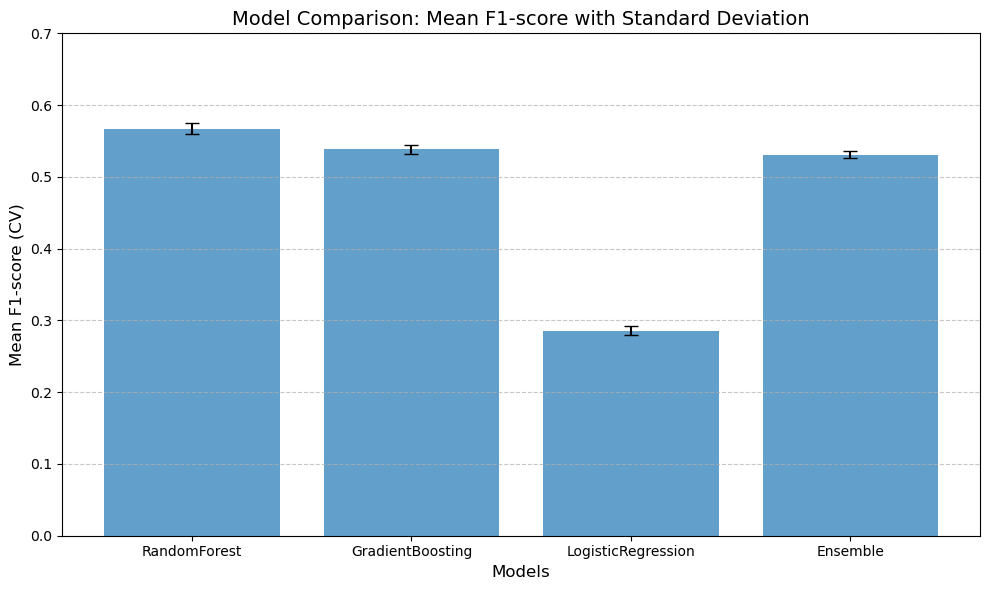

In [72]:
# Jupyter Notebook magic command for inline plotting
%matplotlib inline

import matplotlib.pyplot as plt

# Data for the models
models = ['RandomForest', 'GradientBoosting', 'LogisticRegression', 'Ensemble']
mean_f1_scores = [0.5672, 0.5386, 0.2857, 0.5309]
std_devs = [0.0073, 0.0062, 0.0059, 0.0050]

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(models, mean_f1_scores, yerr=std_devs, capsize=5, alpha=0.7)
plt.xlabel('Models', fontsize=12)
plt.ylabel('Mean F1-score (CV)', fontsize=12)
plt.title('Model Comparison: Mean F1-score with Standard Deviation', fontsize=14)
plt.ylim(0, 0.7)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()





In [56]:
from joblib import dump
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

# Retrain the best model (RandomForestClassifier) on the full training data
best_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),  # Ensure `preprocessor` is defined earlier
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

# Fit the pipeline on the training data
best_model_pipeline.fit(X_train, y_train)

# Save the trained pipeline using joblib
model_filename = "best_model_random_forest.joblib"
dump(best_model_pipeline, model_filename)

print(f"Best model saved to {model_filename}")


Best model saved to best_model_random_forest.joblib


In [66]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from joblib import dump, load
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import numpy as np

# Train/Test Split
X = df.drop(columns=['loan_status'])  # Features
y = df['loan_status']  # Target

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Define numeric and categorical features
numeric_features = ['age', 'income', 'loan_amount', 'credit_score']
categorical_features = ['gender', 'education', 'loan_intent']

# Custom feature engineering function
def add_features(X):
    # Ensure input is a DataFrame
    if not isinstance(X, pd.DataFrame):
        X = pd.DataFrame(X, columns=numeric_features)
    
    X['income_to_loan_ratio'] = X['income'] / (X['loan_amount'] + 1e-5)
    X['employment_income_ratio'] = X['income'] / (X['age'] + 1e-5)
    return X

# Preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('scaler', StandardScaler()),
            ('feature_engineering', FunctionTransformer(add_features, validate=False))
        ]), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ]
)

# Train the best model (RandomForestClassifier)
best_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

best_model.fit(X_train, y_train)

# Save the model using joblib
model_filename = "best_model.joblib"
dump(best_model, model_filename)
print(f"Best model saved to {model_filename}")

# Load the model using joblib
loaded_model = load(model_filename)

# Run the model to check outputs
y_pred = loaded_model.predict(X_test)

# Evaluate the model
report = classification_report(y_test, y_pred)
print("\nModel Performance on Test Set:")
print(report)


Best model saved to best_model.joblib

Model Performance on Test Set:
              precision    recall  f1-score   support

           0       0.86      0.96      0.91      7000
           1       0.78      0.46      0.58      2000

    accuracy                           0.85      9000
   macro avg       0.82      0.71      0.75      9000
weighted avg       0.84      0.85      0.84      9000

